

Модель, прогнозирующая выживет ли пассажир Титаника.

Данные взяты с https://www.kaggle.com/c/titanic/data?select=train.csv


In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,\
recall_score, f1_score, r2_score, roc_auc_score, roc_curve, silhouette_score
from scipy.stats import f
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit

Читаем данные из csv

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv('test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Описание столбцов:


*   Ид пассажира
*   Индикатор выжил он или нет

*   Класс пассажира

*   ФИО
*   Пол

*   Возраст
*   Количество родственников на борту

*   Количество родителей/детей на борту
*   Билет
* Стоимость билета

*   Кабина
*   Порт посадки












In [ ]:
train_data.info()
print('\n')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass

Очистим от пустых значений

In [ ]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Text(0.5, 1.0, 'Пропущенные значения обучающей выборки')

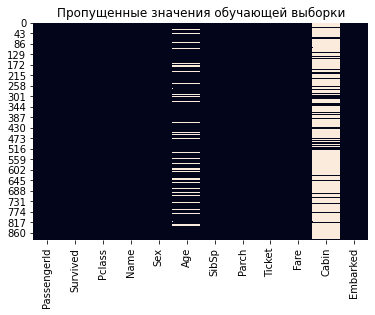

In [ ]:
sns.heatmap(train_data.isnull(), cbar = False).set_title("Пропущенные значения обучающей выборки")

In [ ]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Text(0.5, 1.0, 'Пропущенные знчения тестовой выборки')

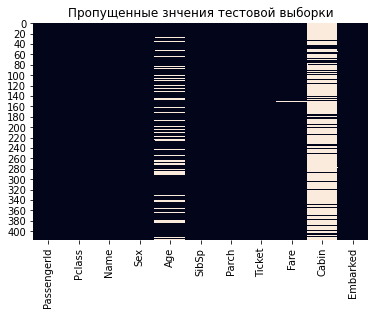

In [ ]:
sns.heatmap(test_data.isnull(), cbar=False).set_title('Пропущенные знчения тестовой выборки')

In [ ]:
train_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [ ]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
str(round(train_data.Survived[train_data['Survived'] == 1].sum() / train_data.shape[0] * 100, 2)) + "%"

'38.38%'

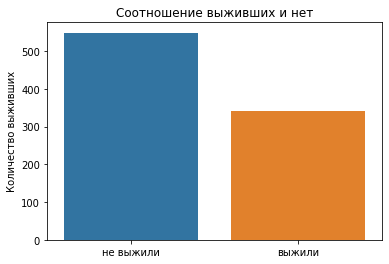

In [ ]:
sns.countplot(x='Survived', data=train_data)
plt.xlabel('')
plt.ylabel('Количество выживших')
plt.title('Соотношение выживших и нет')
plt.xticks([0,1], ('не выжили', 'выжили'))
plt.show()

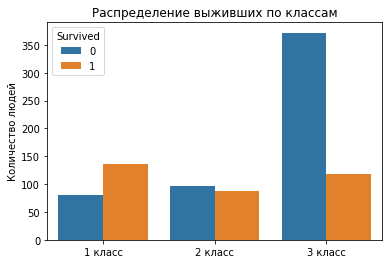

In [ ]:
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Распределение выживших по классам')
plt.xlabel('')
plt.ylabel('Количество людей')
plt.xticks(range(3), ('1 класс', "2 класс", "3 класс"))
plt.show()

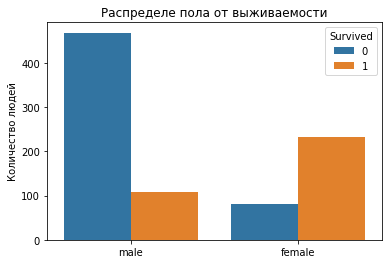

In [ ]:
sns.countplot(x='Sex', hue='Survived', data = train_data)
plt.title('Распределе пола от выживаемости')
plt.xlabel('')
plt.ylabel('Количество людей')
plt.show()

Объединим колонки семейных отношений в общую Family

In [ ]:
train_data['Family'] = train_data['SibSp'] + train_data['Parch']
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


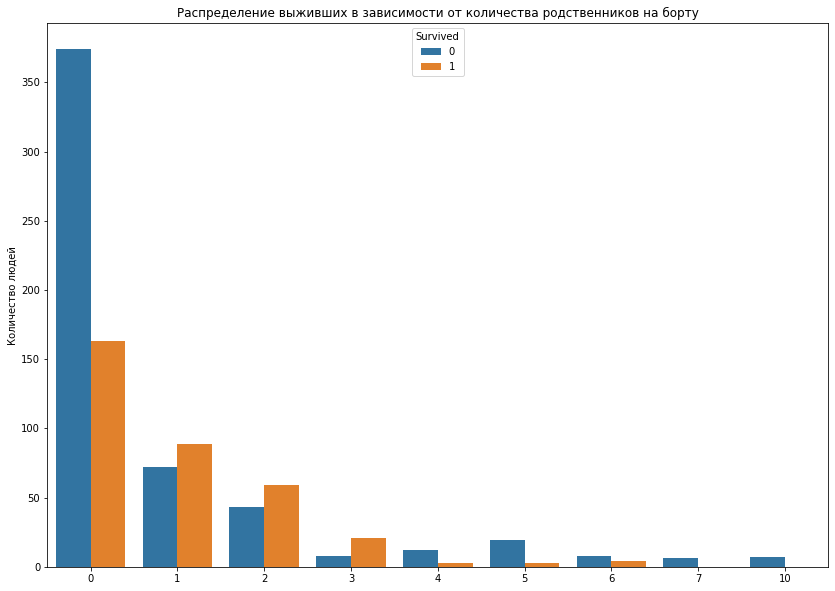

In [ ]:
plt.figure(figsize=(14, 10))
sns.countplot(x='Family', hue='Survived', data=train_data)
plt.title('Распределение выживших в зависимости от количества родственников на борту')
plt.xlabel('')
plt.ylabel('Количество людей')
plt.show()

In [ ]:
train_data['Age'].max()

80.0

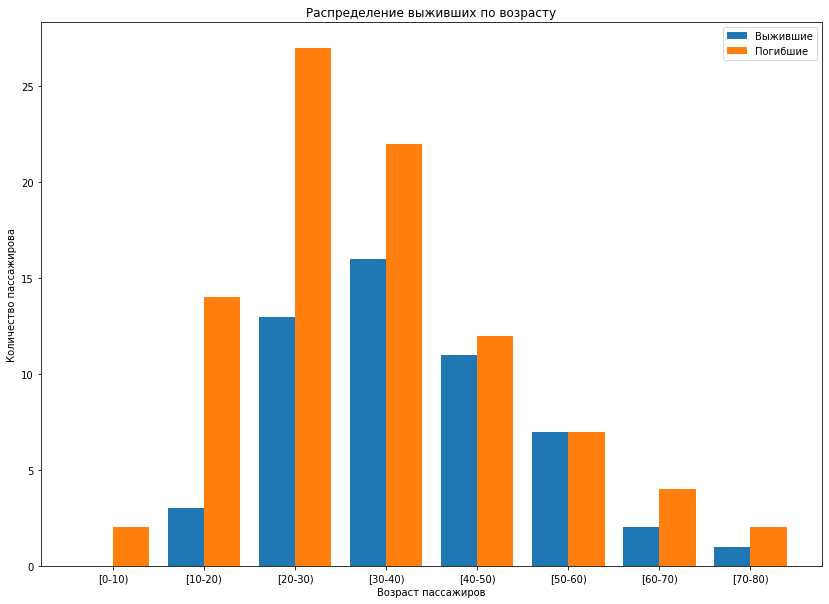

In [ ]:
plt.figure(figsize=(14,10))
plt.bar([i-0.2 for i in range (0,8)],
        [train_data[(train_data['Age'].isin([i, (i+10)])) 
        & (train_data.Survived == 1)].Age.count() for i in range(0, 80, 10)],
        width = 0.4, label='Выжившие')
plt.bar([i+0.2 for i in range (0,8)],
        [train_data[(train_data['Age'].isin([i, (i+10)])) 
        & (train_data.Survived == 0)].Age.count() for i in range(0, 80, 10)],
        width = 0.4, label='Погибшие')
plt.xticks(range(0,8),["["+str(i)+"-"+str(i+10)+")" for i in range(0, 80, 10)])
plt.xlabel('Возраст пассажиров')
plt.ylabel('Количество пассажирова')
plt.title('Распределение выживших по возрасту')
plt.legend()
plt.show()

In [ ]:
train_data.drop(['Ticket'], axis=1, inplace=True)

In [ ]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
Fare             0
Cabin          687
Embarked         2
Family           0
dtype: int64

In [ ]:
train_data[train_data['Embarked'].isna()].head()
train_data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
train_data.loc[train_data['Embarked'].isna(), 'Embarked'] = 'S'
train_data.Embarked.replace(['S', 'C', 'Q'], [0,1,2], inplace=True)

In [ ]:
train_data.Embarked.value_counts()

0    646
1    168
2     77
Name: Embarked, dtype: int64

In [ ]:
firstClassAgeMedian = round(train_data.Age[train_data['Pclass'] == 1].median())
secondClassAgeMedian = round(train_data.Age[train_data['Pclass'] == 2].median())
thirdClassAgeMedian = round(train_data.Age[train_data['Pclass'] == 3].median())

In [ ]:
train_data.loc[(train_data['Age'].isna()) & (train_data['Pclass'] == 1), 'Age'] = firstClassAgeMedian
train_data.loc[(train_data['Age'].isna()) & (train_data['Pclass'] == 2), 'Age'] = secondClassAgeMedian
train_data.loc[(train_data['Age'].isna()) & (train_data['Pclass'] == 3), 'Age'] = thirdClassAgeMedian

In [ ]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
Fare             0
Cabin          687
Embarked         0
Family           0
dtype: int64

In [ ]:
train_data['Deck'], train_data['CabinNumber'] = train_data['Cabin'].str[0], train_data['Cabin'].str[1:]

In [ ]:
train_data.drop(['Cabin', 'Name'], axis=1, inplace=True)

In [ ]:
train_data.loc[train_data['Deck'].isna(), "Deck"] = 0
train_data.loc[train_data['CabinNumber'].isna(), "CabinNumber"] = '0'
train_data.loc[train_data.CabinNumber == ' G7', "Deck"] = "G"
train_data.loc[train_data.CabinNumber == ' G6', "Deck"] = "G"
train_data.loc[train_data.CabinNumber == ' E6', "Deck"] = "E"

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family,Deck,CabinNumber
0,1,0,3,male,22.0,7.2500,0,1,0,0
1,2,1,1,female,38.0,71.2833,1,1,C,85
2,3,1,3,female,26.0,7.9250,0,0,0,0
3,4,1,1,female,35.0,53.1000,0,1,C,123
4,5,0,3,male,35.0,8.0500,0,0,0,0


In [ ]:
train_data.Sex.replace(['male', 'female'], [0,1], inplace=True)

In [ ]:
train_data.Deck.value_counts()

0    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Deck, dtype: int64

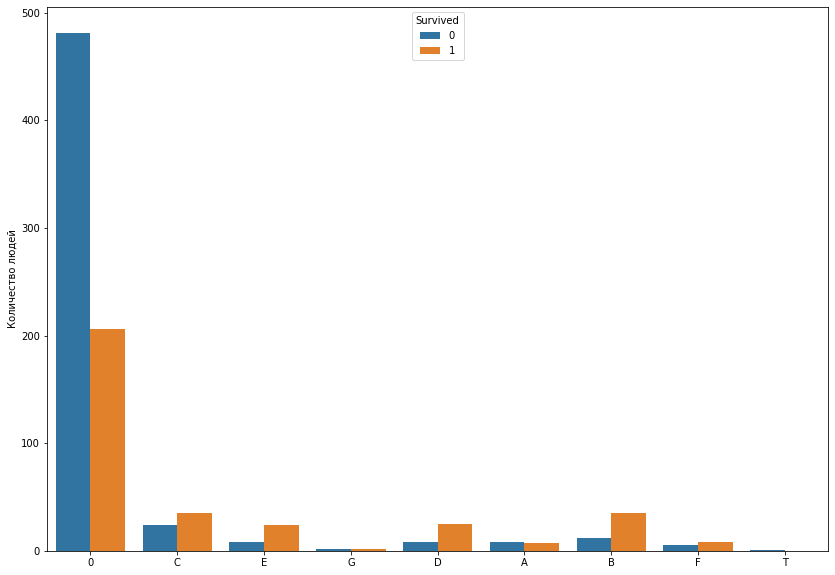

In [ ]:
plt.figure(figsize=(14,10))
sns.countplot(x='Deck', hue='Survived', data=train_data)
plt.xlabel('')
plt.ylabel('Количество людей')
plt.show()

In [ ]:
train_data.replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], [1,2,3,4,5,6,7,8], inplace=True)

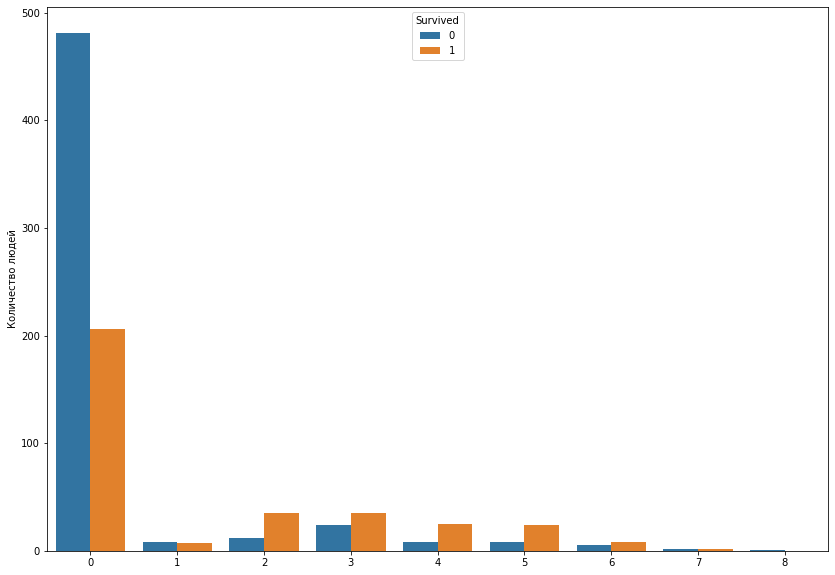

In [ ]:
plt.figure(figsize=(14,10))
sns.countplot(x='Deck', hue='Survived', data=train_data)
plt.xlabel('')
plt.ylabel('Количество людей')
plt.show()

In [ ]:
train_data.CabinNumber = train_data.CabinNumber.str[0:3]

In [ ]:
train_data.CabinNumber.describe()

count     891
unique    102
top         0
freq      687
Name: CabinNumber, dtype: object

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family,Deck,CabinNumber
0,1,0,3,0,22.0,7.2500,0,1,0,0
1,2,1,1,1,38.0,71.2833,1,1,3,85
2,3,1,3,1,26.0,7.9250,0,0,0,0
3,4,1,1,1,35.0,53.1000,0,1,3,123
4,5,0,3,0,35.0,8.0500,0,0,0,0


In [ ]:
train_data.loc[train_data.CabinNumber == ' G7', "CabinNumber"] = "7"
train_data.loc[train_data.CabinNumber == ' E6', "CabinNumber"] = "6"
train_data.loc[train_data.CabinNumber == ' G6', "CabinNumber"] = "6"

In [ ]:
train_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
Family         0
Deck           0
CabinNumber    0
dtype: int64

In [ ]:
train_data.CabinNumber = pd.to_numeric(train_data.CabinNumber)

In [ ]:
train_data.dropna(inplace=True)

In [ ]:
train_data['Is_Alone'] = train_data.Family == 0

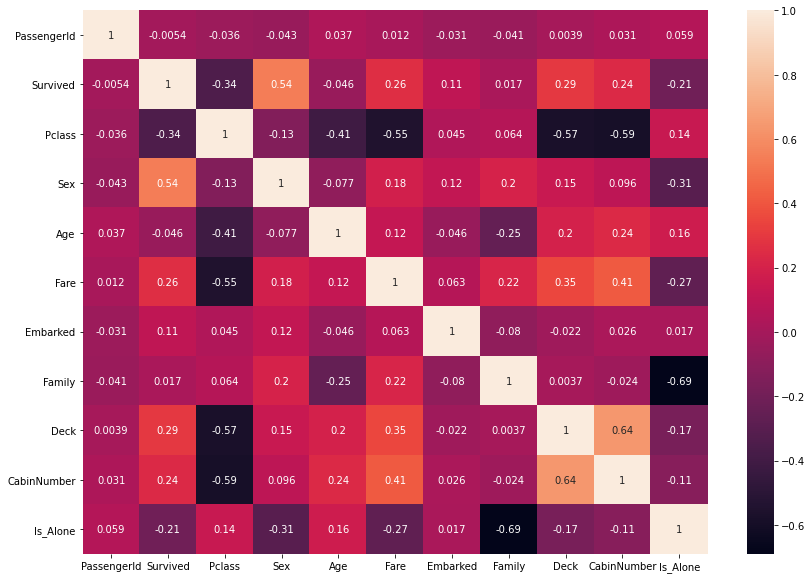

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(data=train_data.corr(), annot=True)

# Предсказание


In [ ]:
y = train_data['Survived']
x = train_data.drop(['Survived', 'PassengerId',"CabinNumber"], axis=1)
sc = StandardScaler()
x = sc.fit_transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=0)

In [ ]:
model = LogisticRegression()
model.fit(x_train, y_train)
logit_predict = model.predict(x_test)

In [ ]:
model.coef_

array([[-0.8006539 ,  1.27924022, -0.55895976,  0.06146486,  0.0589774 ,
        -0.58566239,  0.2431203 , -0.23454026]])

In [ ]:
def metrics(y_test, predictions):
    """Функция выводит метрики качества предсказаний

    Аргументы:
    y_test -- истинные значения personal load
    predictions -- предсказанные моделью значения
    """
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
    print('R^2: {:.2f}'.format(r2_score(y_test, predictions)))
    print('Дисперсия a = {0:.3f}, Дисперсия b = {1:.3f}'.format(np.var(y_test, ddof=1),
                                                                np.var(predictions, ddof=1)))
    print('F-табл: {:.2f}'.format(f.ppf(0.05, 10, 9)))
    print('F-факт: {:.2f}'.format(stats.f_oneway(y_test, predictions)[0]))
    #print(abs(np.mean(y_test) - np.mean(predictions)) / (np.var(y_test) + np.var(predictions)))

In [ ]:
def roc(y_test, predict, probabilities, type):
    global roc_auc
    roc_auc = roc_auc_score(y_test, predict)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label='{} Regression (area = {:0.2f})'.format(type,roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Кривая ошибок(ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
metrics(y_test, logit_predict)

Accuracy: 0.81
Precision: 0.78
Recall: 0.69
F1: 0.73
R^2: 0.19
Дисперсия a = 0.237, Дисперсия b = 0.225
F-табл: 0.33
F-факт: 0.78


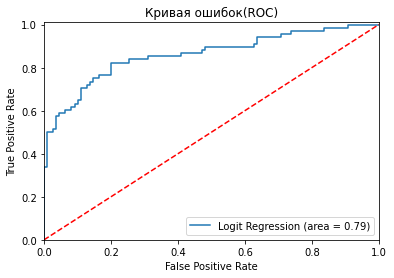

In [ ]:
roc(y_test, logit_predict, model.predict_proba(x_test)[:,1], "Logit")

In [ ]:
x_train = sm.add_constant(x_train)
model = Probit(y_train, x_train.astype(float))
probit_model = model.fit()
print(probit_model.summary2())

Optimization terminated successfully.
         Current function value: 0.438069
         Iterations 6
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.342     
Dependent Variable: Survived         AIC:              641.1816  
Date:               2021-05-17 14:10 BIC:              686.8201  
No. Observations:   709              Log-Likelihood:   -310.59   
Df Model:           9                LL-Null:          -472.06   
Df Residuals:       699              LLR p-value:      3.5074e-64
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     -0.3718     0.0576   -6.4506   0.0000   -0.4847   -0.2588
x1        -0.4694     0.0898   -5.2304   0.0000   -0.6454